# Bachelor Thesis: Sentiment Index using TextBlob

__Author__: Jannick Sicher

The following Jupyter notebook provides the code for the creation of the sentiment index. The notebook further features a trading application that makes use of the sentiment index created within this notebook. The sentiment index is created based on news articles received by the Alchemy API of IBM (Watson News Discovery) that consists of a pre-enriched collection of news data of the past two months. The sentiment index analyses five Swiss based companies, namely the UBS Group, Nestlé, Roche, Novartis, and ABB. The purpose of the sentiment index is to make use of the sentiment of worldwide news articles and decide whether to buy or sell a stock based on the perception of the most relevant news articles provided for each company. 

## Initial Configurations

In [19]:
%matplotlib inline
import sys
import os
import pandas as pd
import json
from watson_developer_cloud import DiscoveryV1
import requests
from nytimesarticle import articleAPI
import time
import nltk
from bs4 import BeautifulSoup as soup
import bs4 as bs
import requests
import re
from textblob import TextBlob
from nltk import word_tokenize
from nltk import tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
from bs4 import BeautifulSoup
import matplotlib
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from textblob_de import TextBlobDE
from urllib.request import urlopen as uReq
from sklearn.preprocessing import StandardScaler
import datetime
import backtrader as bt
import backtrader.feeds as btfeed

### Initial configuration for the IBM Discovery News API ###
discovery = DiscoveryV1(
    version='2018-05-03',
    username='522af75a-3b5f-4300-96c1-10035cb0e22f',
    password='8gxPSA0bJizc')

## Query Function for Alchemy API: News Articles

This section provides a function to call the latest news articles for a company. Just uncomment the following code and change the _"CompanyName"_ with the desired company of your choice. By default, the search query provides only English news articles to simplify the sentiment analysis. However, if you want to receive German news articles, you can change language to _"de"_. 

In [20]:
## Query function to search articles for companies
#qopts = {'query': 'enriched_text.entities.text:UBS', 'language':'en', 'title': 'UBS'}
#UBS = discovery.query('system', 'news-en', qopts)
#print(json.dumps(UBS, indent=2))

## Data Preparation

In the first step of this notebook, I prepare the data for each company. Firstly, I created a JSON file using approximately 500 news articles (the most relevant in the Watson News Discovery database) for each company during the last two months. The JSON file provides all needed information such as the source, URL, text, author, language, etc. In this section, I loaded all JSON files and transformed them into a Pandas dataframe using the Pandas package. After doing that, I saved the csv file for each company. 

### JSON file for UBS

In [21]:
# Load json file of UBS articles
with open('UBS_dataset_new.json') as json_data:
    UBS_json = json.load(json_data)

# Transform 'results' of json file into pandas dataframe
UBS_df = pd.DataFrame(UBS_json['results'])

# Transform date into datetime
UBS_df['datetime'] = pd.to_datetime(UBS_df['publication_date'])

# Save created pandas df to csv
UBS_df.to_csv('UBS_df.csv')

### JSON file for Nestlé

In [22]:
# Load json file of Nestlé articles
with open('Nestle_dataset_new.json') as json_data:
    Nestle_json = json.load(json_data)

# Transform 'results' of json file into pandas dataframe
Nestle_df = pd.DataFrame(Nestle_json['results'])

# Transform date into datetime
Nestle_df['datetime'] = pd.to_datetime(Nestle_df['publication_date'])

# Save created pandas df to csv
Nestle_df.to_csv('Nestle_df.csv')

### JSON file for Roche

In [23]:
# Load json file of Roche articles
with open('Roche_dataset_new.json') as json_data:
    Roche_json = json.load(json_data)

# Transform results json file into pandas dataframe
Roche_df = pd.DataFrame(Roche_json['results'])

# Transform date into datetime
Roche_df['datetime'] = pd.to_datetime(Roche_df['publication_date'])

# Save created pandas df to csv
Roche_df.to_csv('Roche_df.csv')

### JSON file for Novartis

In [24]:
# Load json file of Novartis articles
with open('Novartis_dataset_new.json') as json_data:
    Novartis_json = json.load(json_data)  

# Transform results json file into pandas dataframe
Novartis_df = pd.DataFrame(Novartis_json['results'])    

# Transform date into datetime
Novartis_df['datetime'] = pd.to_datetime(Novartis_df['publication_date'])

# Save created pandas df to csv
Novartis_df.to_csv('Novartis_df.csv') 

### JSON file for ABB

In [25]:
# Load json file of ABB articles
with open('ABB_dataset_new.json') as json_data:
    ABB_json = json.load(json_data)

# Transform results json file into pandas dataframe
ABB_df = pd.DataFrame(ABB_json['results'])  

# Transform date into datetime
ABB_df['datetime'] = pd.to_datetime(ABB_df['publication_date'])

# Save created pandas df to csv
ABB_df.to_csv('ABB_df.csv')

## Sentiment Analysis with TextBlob
The third sentiment analysis uses TextBlob which is a Python library for processing textual data. Textblob "provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more."

As an addition I will try to analyse the subjectivity of each article using the TextBlob library. The sentiment analysis using Textblob thus consists of two scores:


__Polarity__: Sentiment Score (positive or negative)

__Subjectivity__: Score if text is subjective or not

### Sentiment Score of UBS

In [26]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
UBS_df['polarity'] = UBS_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
UBS_df['subjectivity'] = UBS_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [27]:
UBS_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,main_image_url,publication_date,result_metadata,source_type,text,title,url,datetime,polarity,subjectivity
0,NaN,CH,2018-03-09T08:21:34Z,"{'entities': [{'count': 10, 'sentiment': {'sco...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '383c3c4c371211a450fb15a5a547c967a702...,SIX Swiss Exchange | Equity issuer newsfeed,{'enriched_text.semantic_roles.object.entities...,six-swiss-exchange.com,...,NaN,2018-03-09T00:00:00Z,{'score': 17.683195},mainstream,UBS publishes Annual Report 2017 Latest media ...,UBS Group AG,http://www.six-swiss-exchange.com/issuers/serv...,2018-03-09 00:00:00,0.120000,0.37500
1,AP연합뉴스 | 네이버 뉴스,KR,2018-05-03T09:55:57Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': '1e59d0bd5c545cede135fcdb1bf20d1beb3d...,NaN,{'enriched_text.semantic_roles.object.entities...,news.naver.com,...,http://imgnews.naver.net/image/origin/077/2018...,2018-05-03T18:48:00+09:00,{'score': 17.302486},mainstream,"Axel A. Weber, Chairman of the Board of Direct...",Switzerland UBS,http://news.naver.com/main/read.nhn?oid=077&ai...,2018-05-03 09:48:00,0.050000,0.50000
2,From cnbc.com,US,2018-04-16T11:13:10Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '6288a551e9ff88927f298712297ecc64bb3e...,FF All News,{'enriched_text.semantic_roles.object.entities...,forexfactory.com,...,https://www.forexfactory.com/facebookimage.php...,2018-04-16T10:35:00Z,{'score': 17.099733},mainstream,From cnbc.com The super wealthy want more out ...,The ultra-rich want to make money through good...,https://www.forexfactory.com/news.php?do=news&...,2018-04-16 10:35:00,0.223893,0.43683
3,Yen Nee Lee,US,2018-04-16T01:23:30Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '4d5fea48b773dd3534a442c024fd8c192b09...,World News &amp;amp; Analysis,{'enriched_text.semantic_roles.object.entities...,cnbc.com,...,https://fm.cnbc.com/applications/cnbc.com/reso...,2018-04-15T21:21:00-05:00,{'score': 17.018406},mainstream,The super wealthy want more out of their inves...,UBS: Ultra-high net worth investors find susta...,https://www.cnbc.com/2018/04/15/ubs-ultra-high...,2018-04-16 02:21:00,0.260101,0.45202
4,EPA연합뉴스 | 네이버 뉴스,KR,2018-05-03T11:33:08Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': 'ad83676b0e7dd231b26b25a5ce1cfb7b5039...,NaN,{'enriched_text.relations.arguments.entities.t...,news.naver.com,...,http://imgnews.naver.net/image/origin/091/2018...,2018-05-03T18:44:00+09:00,{'score': 16.77806},mainstream,"UBS general assembly Sergio P. Ermotti, Group ...",SWITZERLAND UBS GENERAL ASSEMBLY,http://news.naver.com/main/read.nhn?oid=091&ai...,2018-05-03 09:44:00,0.037500,0.37500


### Sentiment Score of Nestle

In [28]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Nestle_df['polarity'] = Nestle_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Nestle_df['subjectivity'] = Nestle_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [29]:
Nestle_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,main_image_url,publication_date,result_metadata,source_type,text,title,url,datetime,polarity,subjectivity
0,EPA연합뉴스 | 네이버 뉴스,KR,2018-04-12T15:45:52Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': '39e1180c6da58c5c00e2bd49cf5f41f8dcb9...,NaN,{'enriched_text.semantic_roles.object.text': [...,news.naver.com,...,http://imgnews.naver.net/image/origin/091/2018...,2018-04-12T22:54:00+09:00,{'score': 26.085062},mainstream,Nestle annual general meeting in Lausanne A Ne...,SWITZERLAND NESTLE ANNUAL GENERAL MEETING,http://news.naver.com/main/read.nhn?oid=091&ai...,2018-04-12 13:54:00,0.050000,0.500000
1,EPA연합뉴스 | 네이버 뉴스,KR,2018-04-18T13:27:01Z,"{'entities': [{'count': 3, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': '47edd4829253b226a92bc85f1e16afbc1f3a...,NaN,{'enriched_text.semantic_roles.object.text': [...,news.naver.com,...,http://imgnews.naver.net/image/origin/091/2018...,2018-04-18T22:09:00+09:00,{'score': 23.074968},mainstream,Nestle results (FILE) - A file picture dated 0...,(FILE) SWITZERLAND ECONOMY NESTLE 뉴스,http://news.naver.com/main/read.nhn?oid=091&ai...,2018-04-18 13:09:00,0.050000,0.500000
2,NaN,FR,2018-04-25T00:37:16Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [], 'sentiment': {'document': {'s...",NaN,{'sha1': '3f4ad04a276645e05ba83f14eaca15a1e3a2...,Nigeria News (News Reader) |,{'enriched_text.semantic_roles.object.text': [...,nigeria.shafaqna.com,...,NaN,2018-04-24T17:27:00Z,{'score': 22.835794},mainstream,7 hours ago Nestle tops gainers’ chart at NSE ...,Nestle tops gainers’ chart at NSE,http://nigeria.shafaqna.com/EN/NG/5309082,2018-04-24 17:27:00,0.250000,0.333333
3,in_admin,IN,2018-05-04T12:49:27Z,"{'entities': [{'count': 3, 'sentiment': {'scor...","{'entities': [], 'sentiment': {'document': {'s...",NaN,{'sha1': '74c17e617afaf7b34b6b9a5e88699e2d174e...,IBNMoney India In,{'enriched_text.relations.arguments.entities.t...,in.ibnmoney.com,...,NaN,2018-05-04T12:30:00Z,{'score': 21.832844},mainstream,Nestle settles months-long pricing scrap with ...,Nestle settles months-long pricing scrap with ...,http://in.ibnmoney.com/2018/05/04/nestle-settl...,2018-05-04 12:30:00,-0.057407,0.309259
4,NaN,US,2018-05-04T16:50:23Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '3e7f5aa52b48d2ef11432e3276843518d129...,SG Talk - All Forums,{'enriched_text.semantic_roles.subject.text': ...,sgtalk.org,...,NaN,2018-05-04T11:33:00Z,{'score': 21.426325},mainstream,"Nestle , the worlds largest packaged food comp...",Nestle close to deal with Starbucks on its gro...,http://sgtalk.org/mybb/Thread-Nestle-close-to-...,2018-05-04 11:33:00,0.000000,0.000000


### Sentiment Score of Roche

In [30]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Roche_df['polarity'] = Roche_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)

In [31]:
Roche_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,language,main_image_url,publication_date,result_metadata,source_type,text,title,url,datetime,polarity
0,Latisha Jones,US,2018-04-05T05:34:32Z,"{'entities': [{'count': 9, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': 'd2e730fe19a8eb7d9549e40a1474d18bc183...,Daily Political,{'enriched_text.semantic_roles.object.text': [...,dailypolitical.com,...,en,https://www.marketbeat.com/logos/roche-holding...,2018-04-05T05:16:00Z,{'score': 21.85832},mainstream,Tweet Roche (VTX:ROG) ‘s stock had its “buy” r...,Roche (ROG) Given “Buy” Rating at JPMorgan Chase,https://www.dailypolitical.com/2018/04/04/roch...,2018-04-05 05:16:00,-0.025000
1,NaN,US,2018-04-19T05:38:01Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '54e59198dba7b2bc9f0e538b35978326508f...,NaN,{'enriched_text.semantic_roles.object.text': [...,dc101.iheart.com,...,en,https://i.iheart.com/v3/re/new_assets/59c571a8...,2018-04-18T00:00:00Z,{'score': 21.853878},mainstream,Sphere Of Roche: Does Roche Shower Enough? pos...,Sphere Of Roche: Does Roche Shower Enough? | R...,https://dc101.iheart.com/featured/roche/conten...,2018-04-18 00:00:00,-0.128571
2,Joe Pappalardo,US,2018-04-05T05:09:59Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '11c9111b19f05833f739390db5ab499c2a77...,Hillsdale Collegian,{'enriched_text.semantic_roles.object.text': [...,hillsdalecollegian.com,...,en,http://hillsdalecollegian.com/wp-content/uploa...,2018-04-04T13:00:00Z,{'score': 21.78054},mainstream,Roche charges $5 for parking Roche charges $5 ...,Roche charges $5 for parking,http://hillsdalecollegian.com/2018/04/roche-ch...,2018-04-04 13:00:00,0.126263
3,NaN,US,2018-03-08T12:20:13Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '1451ba2ff7b64fa877c0f0a72d009d8ec952...,"NewsDump.com, US News, Headlines, Latest USA N...",{'enriched_text.relations.arguments.entities.t...,newsdump.com,...,en,NaN,2018-03-08T11:40:00Z,{'score': 21.557638},mainstream,Published By: Reuters - Health - Today ZURICH ...,Roche names Pao as Swiss R&D head after Reed e...,http://www.newsdump.com/article/roche-names-pa...,2018-03-08 11:40:00,0.000000
4,Caroline Horne,US,2018-05-01T07:59:45Z,"{'entities': [{'count': 8, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[https://www.marketbeat.com/stocks/VTX/ROG/, h...",{'sha1': 'b7da7697fe180ee46a49467b12254bb31a54...,The Lincolnian Online,{'enriched_text.semantic_roles.object.text': [...,thelincolnianonline.com,...,en,https://www.marketbeat.com/logos/roche-holding...,2018-05-01T09:54:00Z,{'score': 20.9581},mainstream,JPMorgan Chase Reaffirms “Buy” Rating for Roch...,JPMorgan Chase Reaffirms “Buy” Rating for Roch...,https://www.thelincolnianonline.com/2018/05/01...,2018-05-01 09:54:00,-0.041667


### Sentiment Score of Novartis

In [32]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Novartis_df['polarity'] = Novartis_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Novartis_df['subjectivity'] = Novartis_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [33]:
Novartis_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,main_image_url,publication_date,result_metadata,source_type,text,title,url,datetime,polarity,subjectivity
0,NaN,US,2018-03-22T09:22:26Z,"{'entities': [{'count': 3, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '05a21a8dd09f788b7ac1bbd0aa8db1bffd00...,NaN,{'enriched_text.semantic_roles.object.entities...,pharma.remmont.com,...,https://psi.novartis.com/images/ReportSideEffe...,2018-03-20T00:00:00Z,{'score': 23.507174},mainstream,Posted On Mar 20 2018 by admin Reporting side ...,"Report Side Effects, novartis pharmaceutical.#...",http://pharma.remmont.com/report-side-effects-...,2018-03-20 00:00:00,-0.031250,0.193750
1,NaN,CH,2018-05-01T10:15:24Z,"{'entities': [{'count': 17, 'sentiment': {'sco...","{'entities': [{'count': 1, 'sentiment': {'scor...",[http://investors.avexis.com/phoenix.zhtml?c=2...,{'sha1': 'b781074fdad68f34771ce2b64bbaf1ac1b28...,SIX Swiss Exchange | Equity issuer newsfeed,{'enriched_text.semantic_roles.object.entities...,six-swiss-exchange.com,...,NaN,2018-05-01T00:00:00Z,{'score': 23.461473},mainstream,01.05.2018 Novartis AG Novartis provides updat...,Novartis AG,http://www.six-swiss-exchange.com/issuers/serv...,2018-05-01 00:00:00,0.000433,0.475649
2,Marc Bisbal,US,2018-03-12T08:29:34Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '418b62ece773b7a26c1b261b3b93c6a703a7...,T - MarketWatch.com Topics,{'enriched_text.semantic_roles.object.text': [...,marketwatch.com,...,https://mw3.wsj.net/mw5/content/logos/mw_logo_...,2018-03-12T00:00:00-05:00,{'score': 23.104864},mainstream,Novartis AG (NOVN.EB) said Monday that it appo...,Novartis president of operations to exit,http://www.marketwatch.com/story/novartis-pres...,2018-03-12 05:00:00,0.105195,0.207792
3,NaN,GB,2018-03-12T19:33:28Z,"{'entities': [{'count': 18, 'sentiment': {'sco...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '7f90aa8438fb3ab19eeea72ad13f2750d545...,ukcitymedia new uk stock market news,{'enriched_text.semantic_roles.object.entities...,ukcitymedia.co.uk,...,NaN,2018-03-12T06:30:00Z,{'score': 22.599686},mainstream,<p>A uk stock market forum. User postings for ...,NOVARTIS FINANCE S.A. : Directorate change,http://www.ukcitymedia.co.uk/cms40/uk-stockmar...,2018-03-12 06:30:00,0.033333,0.108333
4,ConverterNewsMachine,DE,2018-03-08T06:39:33Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': 'f5150340b45d635538c314e25e500284bc10...,"Slitter, converting, labelling and hot melt news",{'enriched_text.relations.arguments.entities.t...,converternews.com,...,NaN,2018-03-07T17:35:00Z,{'score': 21.109785},mainstream,Home Novartis teams up with American company t...,Novartis teams up with American company to lau...,http://www.converternews.com/novartis-teams-up...,2018-03-07 17:35:00,-0.012727,0.170909


### Sentiment Score of ABB

In [34]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
ABB_df['polarity'] = ABB_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
ABB_df['subjectivity'] = ABB_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [35]:
ABB_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,main_image_url,publication_date,result_metadata,source_type,text,title,url,datetime,polarity,subjectivity
0,NaN,FR,2018-03-07T01:09:56Z,"{'entities': [{'count': 7, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': 'd64a266a38aa8a2db73e46a200b0b60072f3...,The Freethinker Post,{'enriched_text.semantic_roles.object.text': [...,spectrum.ieee.org,...,https://spectrum.ieee.org/image/MzAyNzM3OQ.png,2018-03-06T20:33:00Z,{'score': 24.726908},mainstream,IT ABB Introduces Your Digital Assistant Creat...,ABB Introduces Your Digital Assistant,https://spectrum.ieee.org/computing/it/abb-int...,2018-03-06 20:33:00,0.110490,0.464103
1,Bonnie Powley,US,2018-03-29T09:50:05Z,"{'entities': [{'count': 5, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': 'a3b44e3e65c4aaf29a0bb62eabd0a432215e...,Zolmax,{'enriched_text.semantic_roles.object.text': [...,zolmax.com,...,https://www.marketbeat.com/logos/abb-ltd-logo.png,2018-03-29T09:44:00Z,{'score': 24.70487},mainstream,$456.46 million 13.47 ABB has higher revenue a...,Head-To-Head Analysis: ABB (ABB) & Its Competi...,https://zolmax.com/investing/head-to-head-anal...,2018-03-29 09:44:00,0.084762,0.451190
2,Jennifer Salazar,US,2018-04-08T19:30:06Z,"{'entities': [{'count': 4, 'sentiment': {'scor...","{'entities': [{'count': 2, 'sentiment': {'scor...",NaN,{'sha1': '8ff15c3ebd90d9218332f824e1ebfb3e91d6...,The Ledger Gazette,{'enriched_text.semantic_roles.object.text': [...,ledgergazette.com,...,https://www.marketbeat.com/logos/abb-ltd-logo.png,2018-04-09T01:07:00Z,{'score': 23.089489},mainstream,$774.34 million 21.76 ABB Group has higher rev...,ABB Group (ABB) & Its Rivals Head-To-Head Survey,https://ledgergazette.com/2018/04/08/critical-...,2018-04-09 01:07:00,0.178125,0.346875
3,NaN,AT,2018-04-10T08:11:08Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '5834b282f52039ac9cf680dcca2e4263d6f0...,PR-inside.com News,{'enriched_text.semantic_roles.object.text': [...,pr-inside.com,...,http://www.pr-inside.com/images/uploads/pr/201...,2018-04-10T07:12:00Z,{'score': 22.25545},mainstream,2018-2025 Abbe Refractometers Report on Global...,2018-2025 Abbe Refractometers Report on Global...,http://www.pr-inside.com/abbe-refractometers-r...,2018-04-10 07:12:00,0.000000,0.000000
4,NaN,US,2018-05-01T21:32:28Z,"{'entities': [{'count': 11, 'sentiment': {'sco...","{'entities': [{'count': 2, 'sentiment': {'scor...",NaN,{'sha1': '37d877ac807d5df45ba1b7c517b5dded0bc7...,Automation.com | Automation News <span>The lat...,{'enriched_text.semantic_roles.object.text': [...,automation.com,...,https://www.automation.com/files/pluginfiles/i...,2018-04-30T16:18:00Z,{'score': 22.124786},mainstream,ABB announces ABB Ability Process Performance ...,ABB announces ABB Ability Process Performance ...,https://www.automation.com/products/abb-announ...,2018-04-30 16:18:00,0.090476,0.550000


## Sentiment Index with NZZ Articles

## Analysis of UBS

### NZZ Online: Articles of Past 2 Years

### Loading Articles

In [36]:
a_list = []
for n in range(1,9):    
    sauce = open('UBS_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [37]:
UBS_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
UBS_NZZ_df.head()

,date,text
0,16.05.2018,"Matthias Müller, Peking\n\nDie UBS hat vor zwe..."
1,12.05.2018,Die Regionalbanken fühlen\nsich vom Branchenve...
2,04.05.2018,Ermes Gallarotti\n\nDie UBS will ihren Anteil ...
3,27.04.2018,Starkes Investment Banking
4,26.04.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...


## Sentiment Analysis with Textblob

In [38]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
UBS_NZZ_df['polarity'] = UBS_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
UBS_NZZ_df['subjectivity'] = UBS_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [39]:
# Create .dt.date format
UBS_NZZ_df['datetime'] = pd.to_datetime(UBS_NZZ_df['date'],format='%d.%m.%Y')
UBS_NZZ_df.at[0,'datetime']
UBS_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,16.05.2018,"Matthias Müller, Peking\n\nDie UBS hat vor zwe...",0.384848,0.630303,2018-05-16
1,12.05.2018,Die Regionalbanken fühlen\nsich vom Branchenve...,0.000000,0.000000,2018-05-12
2,04.05.2018,Ermes Gallarotti\n\nDie UBS will ihren Anteil ...,0.000000,0.000000,2018-05-04
3,27.04.2018,Starkes Investment Banking,0.000000,0.000000,2018-04-27
4,26.04.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...,-0.050000,0.100000,2018-04-26


In [40]:
# Creates a function that computes the mean value for each day 
unique_dates = UBS_NZZ_df['date'].unique()

UBS_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = UBS_NZZ_df.loc[UBS_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    UBS_NZZ_New_df = UBS_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [41]:
UBS_NZZ_New_df['date']=pd.to_datetime(UBS_NZZ_New_df['date'],format='%d.%m.%Y')
UBS_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
256,2016-05-28,0.000000,0.300000
255,2016-06-02,0.005556,0.145833
254,2016-06-04,0.000000,0.000000
253,2016-06-10,0.000000,0.000000
252,2016-06-15,-0.093182,0.411364


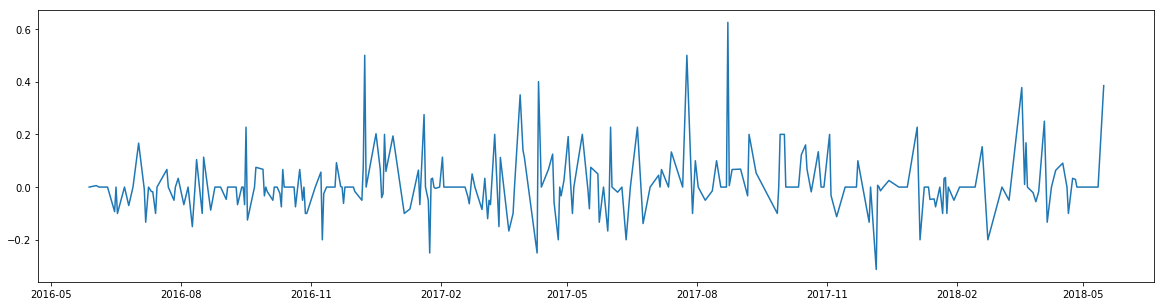

In [42]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(UBS_NZZ_New_df['date'],UBS_NZZ_New_df['polarity'])
#plt.plot(UBS_NZZ_New_df['date'],UBS_NZZ_New_df['subjectivity'])
plt.show()

## Analysis of Nestle

### Loading Articles

In [43]:
a_list = []
for n in range(1,17):    
    sauce = open('Nestle_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])

In [44]:
Nestle_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Nestle_NZZ_df.head()

,date,text
0,20.05.2018,Kleine und mittlere global tätige Unternehmen ...
1,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...
2,15.05.2018,Der Schwarze Kontinent hat schon viele Investo...
3,12.05.2018,Konzernverantwortungsinitiative
4,09.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Diens...


### Sentiment Analysis with Textblob

In [45]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Nestle_NZZ_df['polarity'] = Nestle_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Nestle_NZZ_df['subjectivity'] = Nestle_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [46]:
# Create .dt.date format
Nestle_NZZ_df['datetime'] = pd.to_datetime(Nestle_NZZ_df['date'],format='%d.%m.%Y')
Nestle_NZZ_df.at[0,'datetime']
Nestle_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,20.05.2018,Kleine und mittlere global tätige Unternehmen ...,-0.066667,0.346667,2018-05-20
1,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.100000,0.225000,2018-05-19
2,15.05.2018,Der Schwarze Kontinent hat schon viele Investo...,-0.200000,0.600000,2018-05-15
3,12.05.2018,Konzernverantwortungsinitiative,0.000000,0.000000,2018-05-12
4,09.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Diens...,-0.200000,0.600000,2018-05-09


In [47]:
# Creates a function that computes the mean value for each day 
unique_dates = Nestle_NZZ_df['date'].unique()

Nestle_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Nestle_NZZ_df.loc[Nestle_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    Nestle_NZZ_New_df = Nestle_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [48]:
Nestle_NZZ_New_df['date']=pd.to_datetime(Nestle_NZZ_New_df['date'],format='%d.%m.%Y')
Nestle_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
464,2016-05-24,0.227273,0.545455
463,2016-05-27,0.000000,0.000000
462,2016-05-28,0.100000,0.350000
461,2016-05-31,0.100000,0.300000
460,2016-06-01,-0.200000,0.600000


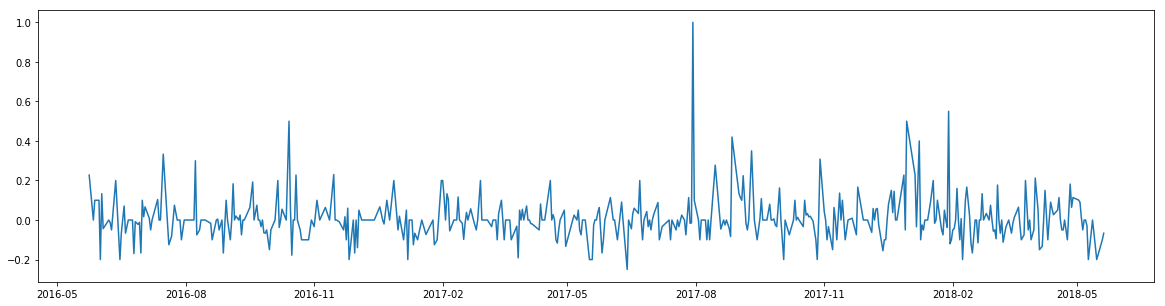

In [49]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Nestle_NZZ_New_df['date'],Nestle_NZZ_New_df['polarity'])
#plt.plot(Nestle_NZZ_New_df['date'],Nestle_NZZ_New_df['subjectivity'])
plt.show()

## Analysis of Novartis

### Loading Articles of past 2 years

In [50]:
a_list = []
for n in range(1,18):    
    sauce = open('Novartis_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [51]:
Novartis_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Novartis_NZZ_df.head()

,date,text
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...
3,20.05.2018,Kleine und mittlere global tätige Unternehmen ...
4,20.05.2018,Franziska Pfister\n\nJoe Jimenez ist an einem ...


## Sentiment Analysis with Textblob

In [52]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Novartis_NZZ_df['polarity'] = Novartis_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Novartis_NZZ_df['subjectivity'] = Novartis_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [53]:
# Create .dt.date format
Novartis_NZZ_df['datetime'] = pd.to_datetime(Novartis_NZZ_df['date'],format='%d.%m.%Y')
Novartis_NZZ_df.at[0,'datetime']
Novartis_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...,0.000000,0.000000,2018-05-20
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...,0.000000,0.000000,2018-05-20
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...,-0.025000,0.266667,2018-05-20
3,20.05.2018,Kleine und mittlere global tätige Unternehmen ...,-0.066667,0.346667,2018-05-20
4,20.05.2018,Franziska Pfister\n\nJoe Jimenez ist an einem ...,0.068182,0.393939,2018-05-20


In [54]:
# Creates a function that computes the mean value for each day 
unique_dates = Novartis_NZZ_df['date'].unique()

Novartis_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Novartis_NZZ_df.loc[Novartis_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    Novartis_NZZ_New_df = Novartis_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [55]:
Novartis_NZZ_New_df['date']=pd.to_datetime(Novartis_NZZ_New_df['date'],format='%d.%m.%Y')
Novartis_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
504,2016-05-22,0.150000,0.500000
503,2016-05-23,0.000000,0.000000
502,2016-05-24,0.113636,0.272727
501,2016-05-25,-0.050000,0.100000
500,2016-05-26,0.000000,0.100000


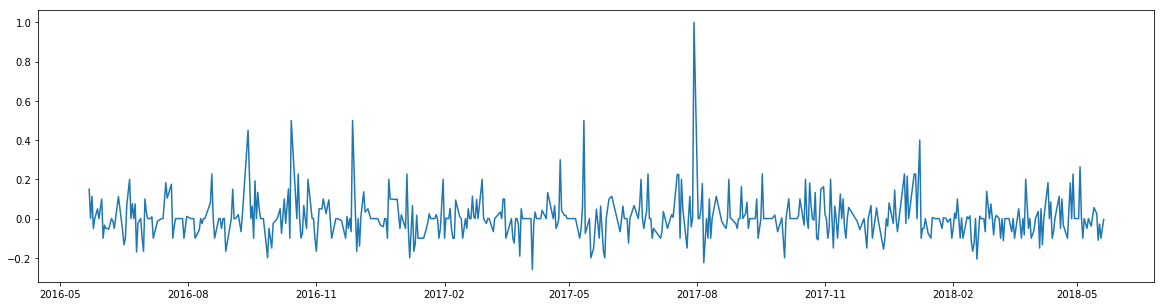

In [56]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Novartis_NZZ_New_df['date'],Novartis_NZZ_New_df['polarity'])
#plt.plot(Novartis_NZZ_New_df['date'],Novartis_NZZ_New_df['subjectivity'])
plt.show()

## Analysis of Roche

In [57]:
a_list = []
for n in range(1,18):    
    sauce = open('Roche_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [58]:
Roche_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Roche_NZZ_df.head()

,date,text
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...
3,19.05.2018,AstraZeneca unter Druck der Anleger
4,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...


## Sentiment Analysis with Textblob

In [59]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Roche_NZZ_df['polarity'] = Roche_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Roche_NZZ_df['subjectivity'] = Roche_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [60]:
# Create .dt.date format
Roche_NZZ_df['datetime'] = pd.to_datetime(Roche_NZZ_df['date'],format='%d.%m.%Y')
Roche_NZZ_df.at[0,'datetime']
Roche_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...,0.000,0.000000,2018-05-20
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...,0.000,0.000000,2018-05-20
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...,-0.025,0.266667,2018-05-20
3,19.05.2018,AstraZeneca unter Druck der Anleger,0.000,0.000000,2018-05-19
4,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.100,0.225000,2018-05-19


In [61]:
# Creates a function that computes the mean value for each day 
unique_dates = Roche_NZZ_df['date'].unique()

Roche_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Roche_NZZ_df.loc[Roche_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    Roche_NZZ_New_df = Roche_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [62]:
Roche_NZZ_New_df['date']=pd.to_datetime(Roche_NZZ_New_df['date'],format='%d.%m.%Y')
Roche_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
496,2016-05-23,0.000000,0.000000
495,2016-05-24,0.227273,0.545455
494,2016-05-25,-0.050000,0.266667
493,2016-05-26,0.000000,0.100000
492,2016-05-28,0.033333,0.116667


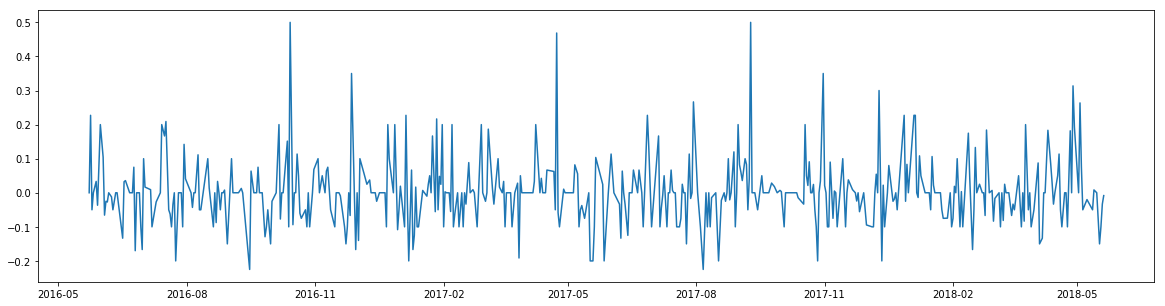

In [63]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Roche_NZZ_New_df['date'],Roche_NZZ_New_df['polarity'])
#plt.plot(Roche_NZZ_New_df['date'],Roche_NZZ_New_df['subjectivity'])
plt.show()